In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import matplotlib.colors

%matplotlib inline

In [2]:
smileon = pd.read_csv('../data/smileon.csv',skiprows=2)

C:\Users\acger\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2,32,36,53,58,59,77,83,89,93,105,127,141,144) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
smileon.shape

(57860, 184)

In [4]:
#Change settings to show all 184 columns
pd.set_option('display.max_columns', None)

In [5]:
smileon.head()

,CallReportNum,ReportVersion,LinkedToCallReportNum,CallDateAndTimeStart,CallDateAndTimeEnd,CallLength,CallerNum,PhoneWorkerNum,WasRealCall,WasHangup,WasSexCall,WasWrongNumber,WasPrankCall,WasSilentCall,GeoCode,GeoAssignment,CityName,CountyName,StateProvince,CountryName,PostalCode,CensusDivision,CensusTrack,CensusReportingArea,211Region,PhoneType,ThirdPartyName,ThirdPartyOrganization,ThirdPartyPhoneNumber,ThirdPartyAddress,ThirdPartyCity,ThirdPartyCounty,ThirdPartyStateProvince,ThirdPartyPostalCode,Narrative,VolunteerComments,Feedback,CallersFeedback,TextField2,TextField3,TextField4,TextField5,TextField6,TextField7,TextField8,TextField9,TextField10,EnteredByWorkerNum,EnteredOn,Supervisor,Reviewed,FeedbackStatus,FeedbackFromPhoneWorkerNum,FeedbackFromPhoneWorkerName,ReferralsMade,IPAddress,OrgNum,VolIdentifier,SMILE ON 60+ Demographic Information - # of People in Household,Birth Year,SMILE ON 60+ Demographic Information - Other Language,SMILE ON 60+ Notes (Optional) - Notes,SMILE ON 60+ Oral Care Encounter - 1351 - Quantity,SMILE ON 60+ Oral Care Encounter - 1354 - Quantity,SMILE ON 60+ Oral Care Encounter - 2140 - Quantity,SMILE ON 60+ Oral Care Encounter - 2150 - Quantity,SMILE ON 60+ Oral Care Encounter - 2160 - Quantity,SMILE ON 60+ Oral Care Encounter - 2161 - Quantity,SMILE ON 60+ Oral Care Encounter - 220 - Quantity,SMILE ON 60+ Oral Care Encounter - 230 - Quantity,SMILE ON 60+ Oral Care Encounter - 2330 - Quantity,SMILE ON 60+ Oral Care Encounter - 2331 - Quantity,SMILE ON 60+ Oral Care Encounter - 2332 - Quantity,SMILE ON 60+ Oral Care Encounter - 2335 - Quantity,SMILE ON 60+ Oral Care Encounter - 2390 - Quantity,SMILE ON 60+ Oral Care Encounter - 2391 - Quantity,SMILE ON 60+ Oral Care Encounter - 2392 - Quantity,SMILE ON 60+ Oral Care Encounter - 2393 - Quantity,SMILE ON 60+ Oral Care Encounter - 2394 - Quantity,SMILE ON 60+ Oral Care Encounter - 2915 - Quantity,SMILE ON 60+ Oral Care Encounter - 2920 - Quantity,SMILE ON 60+ Oral Care Encounter - 2933 - Quantity,SMILE ON 60+ Oral Care Encounter - 2940 - Quantity,SMILE ON 60+ Oral Care Encounter - 2950 - Quantity,SMILE ON 60+ Oral Care Encounter - 2954 - Quantity,SMILE ON 60+ Oral Care Encounter - 2955 - Quantity,SMILE ON 60+ Oral Care Encounter - 2980 - Quantity,SMILE ON 60+ Oral Care Encounter - 3220 - Quantity,SMILE ON 60+ Oral Care Encounter - 4341 - Quantity,SMILE ON 60+ Oral Care Encounter - 4342 - Quantity,SMILE ON 60+ Oral Care Encounter - 6930 - Quantity,SMILE ON 60+ Oral Care Encounter - 6980 - Quantity,SMILE ON 60+ Oral Care Encounter - 7111 - Quantity,SMILE ON 60+ Oral Care Encounter - 7140 - Quantity,SMILE ON 60+ Oral Care Encounter - 7210 - Quantity,SMILE ON 60+ Oral Care Encounter - 7220 - Quantity,SMILE ON 60+ Oral Care Encounter - 7230 - Quantity,SMILE ON 60+ Oral Care Encounter - 7240 - Quantity,SMILE ON 60+ Oral Care Encounter - 7241 - Quantity,SMILE ON 60+ Oral Care Encounter - 7250 - Quantity,SMILE ON 60+ Oral Care Encounter - 7261 - Quantity,SMILE ON 60+ Oral Care Encounter - 7285 - Quantity,SMILE ON 60+ Oral Care Encounter - 7286 - Quantity,SMILE ON 60+ Oral Care Encounter - 7310 - Quantity,SMILE ON 60+ Oral Care Encounter - 7311 - Quantity,SMILE ON 60+ Oral Care Encounter - 7320 - Quantity,SMILE ON 60+ Oral Care Encounter - 7321 - Quantity,SMILE ON 60+ Oral Care Encounter - 7410 - Quantity,SMILE ON 60+ Oral Care Encounter - 7411 - Quantity,SMILE ON 60+ Oral Care Encounter - 7412 - Quantity,SMILE ON 60+ Oral Care Encounter - 7413 - Quantity,SMILE ON 60+ Oral Care Encounter - 7414 - Quantity,SMILE ON 60+ Oral Care Encounter - 7415 - Quantity,SMILE ON 60+ Oral Care Encounter - 7440 - Quantity,SMILE ON 60+ Oral Care Encounter - 7450 - Quantity,SMILE ON 60+ Oral Care Encounter - 7451 - Quantity,SMILE ON 60+ Oral Care Encounter - 7460 - Quantity,SMILE ON 60+ Oral Care Encounter - 7461 - Quantity,SMILE ON 60+ Oral Care Encounter - 7471 - Quantity,SMILE ON 60+ Oral Care Encounter - 7510 - Quantity,SMILE ON 60+ Oral Care Encounter - 7511 - Quantity,SMILE 

In [6]:
#80% of this data set are NaN values
smileon.isna().sum().sum()

8362796

In [7]:
#Drop unnecessary columns
smileon = smileon.drop(columns = ['WasRealCall', 'WasHangup', 'WasSexCall', 'WasWrongNumber', 'WasPrankCall', 'WasSilentCall',
                      'GeoCode', 'GeoAssignment', 'CensusDivision', 'CensusTrack', 'CensusReportingArea', '211Region', 
                      'ThirdPartyName', 'ThirdPartyOrganization', 'ThirdPartyPhoneNumber', 'ThirdPartyAddress',
                      'ThirdPartyCity', 'ThirdPartyCounty', 'ThirdPartyStateProvince', 'ThirdPartyPostalCode',
                      'VolunteerComments', 'CallersFeedback', 'TextField2', 'TextField3', 'TextField4', 'TextField5',
                      'TextField6', 'TextField7', 'TextField8', 'TextField9', 'TextField10', 'Supervisor', 'IPAddress',
                      'VolIdentifier'])

## 1. Who has Smile On been serving? (number of patients, age, gender, etc.)?
### Patient demographic columns:
##### .groupby('CallerNum') - Number of unique patients
##### ['Birth Year'] 
##### ['SMILE ON 60+ Demographic Information - # of People in Household'] 
##### ['SMILE ON 60+ Demographic Information - Preferred Language/Language Needed'] 
##### ['SMILE ON 60+ Demographic Information - Other Language']
##### ['SMILE ON 60+ Demographic Information - Gender'] 
##### ['SMILE ON 60+ Demographic Information - Household Income Level']

In [8]:
# Create dataframe of each unique patient's initial call
patients = smileon.sort_values(by='CallDateAndTimeStart', ascending = True).groupby('CallerNum').first().reset_index()
# With the 'patients' dataframe, we may evaluate the demographics of patients without duplicates skewing the results

In [9]:
len(patients)

10711

### 10,711 Unique Patients

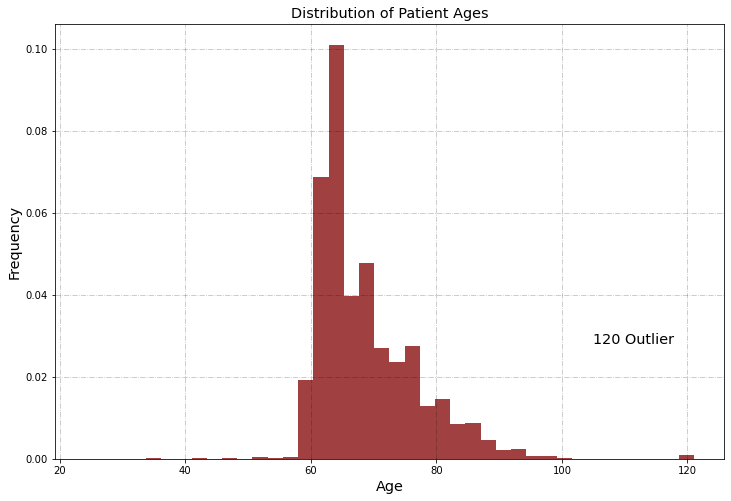

In [10]:
# Change type of column containing patient's first call to datetime64 to do time calculations
patients['CallDateAndTimeStart'] = patients['CallDateAndTimeStart'].astype('datetime64')

# Drop syntax issues within patient's birth years and change type to integer from string
patients = patients.drop(patients.loc[patients['Birth Year'] == '#NUM!'].index)
patients = patients.drop(patients.loc[patients['Birth Year'] == '#VALUE!'].index)
patients['Birth Year'] = patients['Birth Year'].astype('int')

# Create new column named 'Age' that calculates a patient's age as a number rather than birth year
# Subtract first call date from birth year
# Drop outlier age numbers
patients['Age'] = patients['CallDateAndTimeStart'].dt.year - patients['Birth Year']
patients = patients.drop(patients.loc[patients['Age'] == -3225].index)
patients = patients.drop(patients.loc[patients['Age'] == -333].index)
patients = patients.drop(patients.loc[patients['Age'] == -279].index)
patients = patients.drop(patients.loc[patients['Age'] == -21].index)
patients = patients.drop(patients.loc[patients['Age'] == 0].index)
patients = patients.drop(patients.loc[patients['Age'] == 1].index)
patients = patients.drop(patients.loc[patients['Age'] == 119].index)
patients = patients.drop(patients.loc[patients['Age'] == 118].index)

# Use 'Age' column as it's own data frame to create a visual representation 
ages = patients['Age']
plt.figure(figsize=(12,8))
n, bins, patches = plt.hist(ages, 40, density=True, facecolor='maroon', alpha=0.75)
plt.xlabel('Age',size='x-large')
plt.ylabel('Frequency', size='x-large')
plt.title('Distribution of Patient Ages', size='x-large')
plt.text(105, .028, r'120 Outlier', size='x-large')
plt.grid(True, color='black', alpha = 0.25, linestyle='-.')
plt.savefig('../visuals/ages.png')

## Most of SmileOn's patients are in their 60's and 70's.
##### Mean - 68
##### Median - 66
##### Mode - 64

In [11]:
patients['Age'].value_counts()

64     914
61     913
63     898
62     853
65     787
      ... 
101      1
35       1
41       1
28       1
24       1
Name: Age, Length: 62, dtype: int64

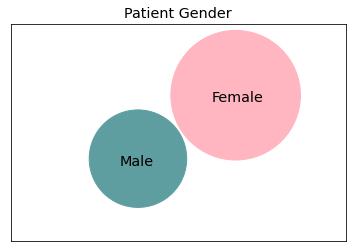

In [12]:
# Visualization showing distribution between patient gender
gender = patients['SMILE ON 60+ Demographic Information - Gender'].value_counts()
# Prepare a list of integers

val = [1, 3801, 6719]
# 6719 Female, 3801 Male, 1 Transgender
 
# Prepare a list of sizes that increases with values in val
sizevalues = [i*2.5 for i in val]

# Prepare a list of colors
plotcolor = ['red','cadetblue','lightpink']
 
# Draw a scatter plot of val points with sizes in sizevalues and
plt.scatter(val, val, s=sizevalues, c=plotcolor)
 
# Draw grid lines with red color and dashed style
plt.grid(color='red', linestyle='-.', linewidth=0.4)
plt.text(6000, 6400, r'Female', size='x-large')
plt.text(3250, 3500, r'Male', size='x-large')
plt.title('Patient Gender', size='x-large')
plt.xticks([])
plt.yticks([])
# Set axis limits to show the markers completely
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.savefig('../visuals/malefemale.png')
plt.show()

## SmileOn's patients are 64% female, 36% male
### 1 Transgender, 1 Other

In [13]:
patients['SMILE ON 60+ Demographic Information - Gender'].value_counts()

Female         6720
Male           3802
Other             1
Transgender       1
Name: SMILE ON 60+ Demographic Information - Gender, dtype: int64

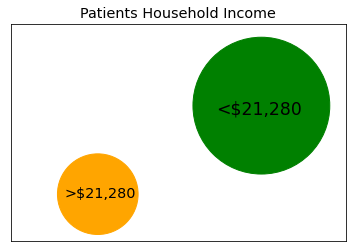

In [14]:
# Same visualization for patient income level
val = [2601, 7487]
# 2,601 patients with income >$21,280, 7,487 patients with income <$21,280
 
# Prepare a list of sizes that increases with values in val
sizevalues = [i*2.5 for i in val]

# Prepare a list of colors
plotcolor = ['orange','green']
 
# Draw a scatter plot of val points with sizes in sizevalues and
# colors in plotcolor
plt.scatter(val, val, s=sizevalues, c=plotcolor)
 
# Draw grid lines with red color and dashed style
plt.grid(color='red', linestyle='-.', linewidth=0.4)
plt.text(6150, 7000, r'<$21,280', size='xx-large')
plt.text(1600, 2400, r'>$21,280', size='x-large')
plt.xticks([])
plt.yticks([]) 
# Set axis limits to show the markers completely
plt.xlim(0, 10000)
plt.ylim(0, 12000)
plt.title('Patients Household Income', size='x-large')
plt.savefig('../visuals/income.png')
plt.show()

## 74% of patients have a yearly income of under $21,280. This is below the poverty-level in Tennessee for 1-3 person households.  

In [15]:
patients['SMILE ON 60+ Demographic Information - Household Income Level'].value_counts()

$0 - $21 280     7488
$21246-$24280    1418
$24281-$27315     438
$28806-$32920     389
$32921-$37035     146
$41561-$46755      80
$36366-$41560      68
$43926-$50200      20
$50201-$56475      12
$51486-$58840       8
$59046-$67480       8
$58841-$66195       6
$84761-$95355       3
$67481-$75915       2
$66606-$76120       2
$76121-$85635       2
Name: SMILE ON 60+ Demographic Information - Household Income Level, dtype: int64

<ipython-input-16-761d0bb8d9e5>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  household = patients['SMILE ON 60+ Demographic Information - # of People in Household'].astype('str').str.replace('.0','').str.replace('_____','').str.replace('_','').str.replace('None','')


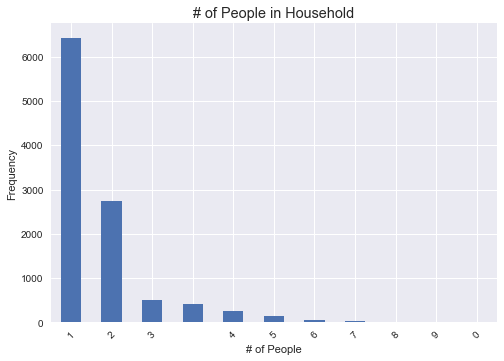

In [16]:
# Seaborn bar chart counting the number of people in each patient's household
plt.style.use('seaborn')

# Drop outliers in this column
patients = patients.drop(patients.loc[patients['SMILE ON 60+ Demographic Information - # of People in Household'] == '1886'].index)
patients = patients.drop(patients.loc[patients['SMILE ON 60+ Demographic Information - # of People in Household'] == '2864'].index)
patients = patients.drop(patients.loc[patients['SMILE ON 60+ Demographic Information - # of People in Household'] == '112'].index)
household = patients['SMILE ON 60+ Demographic Information - # of People in Household'].astype('str').str.replace('.0','').str.replace('_____','').str.replace('_','').str.replace('None','')

# Create the bar chart using Seaborn 
household.value_counts().plot(kind='bar')
plt.title('# of People in Household', size='x-large')
plt.xlabel('# of People')
plt.ylabel('Frequency')
plt.xticks(rotation = 45)
plt.savefig('../visuals/household.png');

## SmileOn patients typically live in a one or two person household

In [17]:
household.value_counts()

1    6428
2    2735
3     506
      412
4     264
5     155
6      57
7      34
8      15
9       5
0       3
Name: SMILE ON 60+ Demographic Information - # of People in Household, dtype: int64

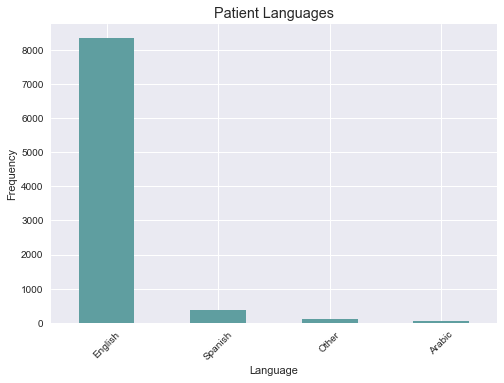

In [18]:
# Same visualization showing patient's preferred languages
preflang = patients['SMILE ON 60+ Demographic Information - Preferred Language/Language Needed'].value_counts()

preflang.plot(kind='bar',color='cadetblue')
plt.title('Patient Languages', size='x-large')
plt.xlabel('Language')
plt.ylabel('Frequency')
plt.xticks(rotation = 45)
plt.savefig('../visuals/lang.png');

## Most patients choose english as their preferred language

In [19]:
preflang

English    8348
Spanish     375
Other       116
Arabic       64
Name: SMILE ON 60+ Demographic Information - Preferred Language/Language Needed, dtype: int64

## 2. Explore the impact of the Smile On program and the outcomes that are produced for clients. Are clients seeing improvement through the Smile On program?
### Columns to evaluate the impact of the SmileOn program (KPIs) :
#### 'SMILE ON 60+ Treatment Plan - Was a treatment plan developed?'
#### 'SMILE ON 60+ Treatment Plan - Was the enrollee able to be restored to function (can chew) and "social six" esthetics (top front six teeth are present and disease free)'
## We solved this by a creating data frame that contains a patient's first and last visit to evaluate the program's impact from start to finish
### Only patients who've had a treatment plan developed and have had at least two visits are conisdered in this sample size

In [20]:
# Create a dataframe for each patient's first and last visit, then concatenate the two tables
patientlastcall = smileon.sort_values(by='CallDateAndTimeStart').groupby('CallerNum').first().reset_index()
patientfirstcall = smileon.sort_values(by='CallDateAndTimeStart').groupby('CallerNum').last().reset_index()
patientsample = pd.concat([patientfirstcall,patientlastcall])
patientsample = patientsample.sort_values(by='CallerNum')

# Drop duplicates: If a patient had only one visit, it will appear as both their first and last visit.
patientsample = patientsample.drop_duplicates()

# Filter the dataframe to show only patients that appear twice in the dataframe (first and last visit)
# The duplicates have been removed, but we also must remove the patients who appear once after this (Only one total visit)
patientsample = patientsample.groupby('CallerNum').filter(lambda x: len(x) > 1)

# Drop patients who've had 2 or more visits, but never enrolled in a treatment plan
patientsample = patientsample.drop(patientsample.loc[patientsample['SMILE ON 60+ Treatment Plan - Was a treatment plan developed?'] == 'No'].index)

patientsample.CallerNum.nunique()

8074

## 8,074 unique patients that have had a first and last visit and started a treatment plan

In [21]:
patientsample['SMILE ON 60+ Treatment Plan - Was the enrollee able to be restored to function (can chew) and "social six" esthetics (top front six teeth are present and disease free)'].value_counts()

Yes    5422
No     5134
Name: SMILE ON 60+ Treatment Plan - Was the enrollee able to be restored to function (can chew) and "social six" esthetics (top front six teeth are present and disease free), dtype: int64

In [22]:
# Move all patients who have answered "No" on their first visit to a separate dataframe
no = patientsample.loc[patientsample['SMILE ON 60+ Treatment Plan - Was the enrollee able to be restored to function (can chew) and "social six" esthetics (top front six teeth are present and disease free)'] == 'No']
no = no.groupby('CallerNum').first()
len(no)

3338

In [23]:
# Move all patients who answered "Yes" on their last visit to another seperate dataframe
yes = patientsample.loc[patientsample['SMILE ON 60+ Treatment Plan - Was the enrollee able to be restored to function (can chew) and "social six" esthetics (top front six teeth are present and disease free)'] == 'Yes']
yes = yes.groupby('CallerNum').last()
len(yes)

3482

In [24]:
# Concatenate the 'yes' and 'no' dataframes
# Filter again to only show caller numbers that appear twice
# Doing this will create a dataframe of only patients who answered "No" on the first visit, and "Yes" on the second
# Divide the length of the dataframe by two to find the exact number of patients who found improvement through SmileOn (Two entries for each patient)
improvement = pd.concat([yes,no])
improvement = improvement.groupby('CallerNum').filter(lambda x: len(x) > 1)
improvement = improvement.sort_values(by=['CallerNum','CallDateAndTimeStart'])
len(improvement)/2

1542.0

## 1,542 patients saw improvement through the SmileOn program

In [25]:
# To find patients who did not find improvement through the SmileOn Program, I recreate the "no" dataframe, but rename it "noimprovement"
# Patients who have answered 'No' on either their first or last visit will be found in this dataframe
# Filter based on caller number again to find patients who appear twice, meaning they answered "No" both times
# Dividing the length of this dataframe by two will give the exact number of patients who did not find improvement 
noimprovement = patientsample.loc[patientsample['SMILE ON 60+ Treatment Plan - Was the enrollee able to be restored to function (can chew) and "social six" esthetics (top front six teeth are present and disease free)'] == 'No']
noimprovement = noimprovement.groupby('CallerNum').filter(lambda x: len(x) > 1)
len(noimprovement)/2

1796.0

## 1,796 patients that enrolled in a treatment program didn't see improvement by their final visit

## 3. Is there any correlation between procedures given and improved outcomes?
### First, clean and transform the procedure column to isolate just code numbers 
### Convert the codes dataframe into a list to do calculations
### See which procedures are associated with improved outcomes by using the 'improvement' dataframe

In [29]:
# Distribution of code #'s by calls
# Filtering for the codes only
codes = smileon.filter(regex = '\d{3}')
regex = re.compile(r'\D')
codes.columns = [regex.sub('', x) for x in codes.columns]
codes.columns = [x[2:] for x in codes.columns]

# Fix spelling errors in dental codes
codes.loc[542, '7320'] = 2.0
codes.loc[945, '7140'] = 4.0
codes.loc[271, '4342'] = 2.0
codes.loc[1369, '2393'] = 1.0
codes.loc[741, '2950'] = 1.0

# Set codes up to be reinserted
codes = codes.fillna(0)
codes = codes.astype('float64')

# Creating dataframe, changed the code column to a list
dentalcodes = codes.columns.values.tolist()

# Took codes dataframe and transposed to easily sum them and turn it into a list
transpose = codes.transpose()
answers = np.sum(transpose, axis = 1).tolist()

# Making the dataframe
procedure_count = pd.DataFrame(list(zip(dentalcodes, answers)), columns = ['code', 'count'])

C:\Users\acger\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [30]:
procedure_count.sort_values(by='count',ascending = False)

,code,count
31,7140,15982.0
7,230,3409.0
1,1354,2892.0
26,4341,2558.0
13,2391,1561.0
...,...,...
48,7413,0.0
23,2955,0.0
39,7285,0.0
6,220,0.0


In [31]:
# 7140: Extraction - erupted tooth or exposed root - 15
# 230: No Code - Denture step Mandibular
# 1354: Interim caries arresting medicament application (silver ion products) per tooth - 5
# 4341: Periodontal scaling/root planing 4+ teeth per quadrant - 45
# 2391: Posterior one surface resin  - 15

In [37]:
# Of the patients who saw improvement from the SmileOn program, what are the most common procedures?
improvement['SMILE ON 60+ Oral Care Encounter - What care was provided to the enrollee? (Select all that apply)'].value_counts().head().reset_index()

,index,SMILE ON 60+ Oral Care Encounter - What care was provided to the enrollee? (Select all that apply)
0,No Code - Denture step Mandibular: may be used...,631
1,7140 - Extraction - erupted tooth or exposed r...,159
2,No Code - Denture step Maxillary: may be used ...,76
3,No Code - Denture step Mandibular: may be used...,76
4,150 - Comprehensive Oral Evaluation -new or es...,56


## "Denture step Mandibular", followed by "Extraction - erupted tooth or exposed root" the most common procedures for patients who improved through the SmileOn program

In [38]:
#And for patients who saw no improvement?
noimprovement['SMILE ON 60+ Oral Care Encounter - What care was provided to the enrollee? (Select all that apply)'].value_counts().head().reset_index()

,index,SMILE ON 60+ Oral Care Encounter - What care was provided to the enrollee? (Select all that apply)
0,No Code - Denture step Mandibular: may be used...,374
1,7140 - Extraction - erupted tooth or exposed r...,297
2,150 - Comprehensive Oral Evaluation -new or es...,160
3,150 - Comprehensive Oral Evaluation -new or es...,121
4,150 - Comprehensive Oral Evaluation -new or es...,113


## The same codes are associated with patients who didn't improve through the program